# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

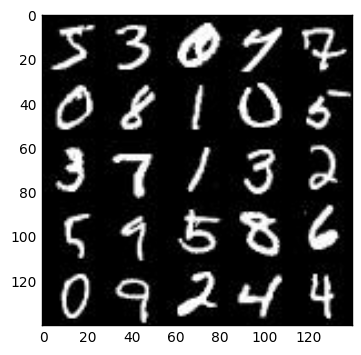

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

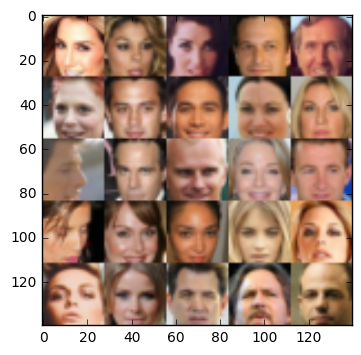

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1


/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/ipykernel/__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs = tf.placeholder(tf.float32, shape=[None, image_width, image_height, image_channels], name='inputs')
    Z = tf.placeholder(tf.float32, shape=[None, z_dim], name='Z')
    learning_rate = tf.placeholder(tf.float32, name='lr')

    return (inputs, Z, learning_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def leakly(x, leak=0.2):
    """
    leakly relu
    """
    return tf.maximum(leak * x, x)

def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    _, w, h, c = images.shape
    kernel_init = tf.random_normal_initializer(stddev=0.05)
    with tf.variable_scope('discriminator', reuse=reuse):
        conv_layer1 = tf.layers.conv2d(images, 64, 4, strides=2, padding='SAME')
        conv_layer1 = tf.layers.batch_normalization(conv_layer1, training=True)
        conv_layer1 = leakly(conv_layer1)
        
        conv_layer2 = tf.layers.conv2d(conv_layer1, 128, 4, strides=2, padding='SAME')
        conv_layer2 = tf.layers.batch_normalization(conv_layer2, training=True)
        conv_layer2 = leakly(conv_layer2)
        
        conv_layer3 = tf.layers.conv2d(conv_layer2, 256, 4, strides=2, padding='SAME')
        conv_layer3 = tf.layers.batch_normalization(conv_layer3, training=True)
        conv_layer3 = leakly(conv_layer3)
        
        flatten = tf.reshape(conv_layer3, [-1, 4*4*256])
        logits = tf.layers.dense(flatten, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [11]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    kernel_init = tf.truncated_normal_initializer(mean=0.0, stddev=0.05)
    
    with tf.variable_scope('generator', reuse = not is_train):
        
        fc_layer1 = tf.layers.dense(z, 4*4*512)
        fc_layer1 = tf.reshape(fc_layer1, [-1, 4, 4, 512])
        fc_layer1 = tf.layers.batch_normalization(fc_layer1, training=is_train)
#         fc_layer1 = tf.nn.relu(fc_layer1)
        fc_layer1 = leakly(fc_layer1)
        
        conv_layer1 = tf.layers.conv2d_transpose(fc_layer1, 256, kernel_size=4, strides=1, padding='valid')
        conv_layer1 = tf.layers.batch_normalization(conv_layer1, training=is_train)
#         conv_layer1 = tf.nn.relu(conv_layer1)
        conv_layer1 = leakly(conv_layer1)
        
        conv_layer2 = tf.layers.conv2d_transpose(conv_layer1, 128, kernel_size=4, strides=2, padding='SAME')
        conv_layer2 = tf.layers.batch_normalization(conv_layer2, training=is_train)
        conv_layer2 = leakly(conv_layer2)
        
        conv_layer3 = tf.layers.conv2d_transpose(conv_layer2, out_channel_dim, kernel_size=4, strides=2, padding='SAME')
        conv_layer3 = tf.tanh(conv_layer3)
   
        return conv_layer3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [12]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    gZ = generator(input_z, out_channel_dim, is_train=True)
    dZ_out_true, dZ_logits_true = discriminator(input_real, reuse=False)
    dZ_out_fake, dZ_logits_fake = discriminator(gZ, reuse=True)
    smooth = 0.1
 
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(dZ_logits_true)*(1-smooth), logits=dZ_logits_true))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.zeros_like(dZ_out_fake), logits=dZ_logits_true))
    d_loss_total = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(dZ_logits_fake), logits=dZ_logits_fake))
    
    return (d_loss_total, g_loss)
  

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [13]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    tvars = tf.trainable_variables()
    d_vars = [var for var in tvars if var.name.startswith('discriminator')]
    g_vars = [var for var in tvars if var.name.startswith('generator')]
    
    all_ops = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
    d_ops = [var for var in all_update_ops if var.name.startswith('generator')]
    g_ops = [var for var in all_update_ops if var.name.startswith('discriminator')]
    
    with tf.control_dependencies(d_ops):
        d_optimizer = tf.train.AdamOptimizer(learning_rate, beta1).minimize(d_loss, var_list=d_vars)
        
    with tf.control_dependencies(g_ops):
        g_optimizer = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=g_vars)
    
    return (d_optimizer, g_optimizer)

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [9]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np
import time

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [10]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    N, h, w, c = data_shape
    inputs, Z_input, learning_rate_input = model_inputs(w, h, c, z_dim)
    dis_loss, gen_loss = model_loss(inputs, Z_input, c)
    dis_optimizer, gen_optimizer = model_opt(dis_loss, gen_loss, learning_rate, beta1)
    dis_costs = []
    gen_costs = []
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            i = 0
            for batch_images in get_batches(batch_size):
                i += 1
                batch_images *= 2
                Z = np.random.uniform(low=-1, high=1, size=(batch_size, z_dim))
                
                sess.run(dis_optimizer, feed_dict={inputs: batch_images, Z_input: Z})
                sess.run(gen_optimizer, feed_dict={Z_input: Z})
                
                if i % 10 == 0:
                    d_cost = sess.run(dis_loss, feed_dict={inputs: batch_images, Z_input: Z})
                    g_cost = sess.run(gen_loss, feed_dict={Z_input: Z})
                    dis_costs.append(d_cost)
                    gen_costs.append(g_cost)
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(d_cost),
                          "Generator Loss: {:.4f}".format(g_cost))
                if i % 100 == 0:
                    show_generator_output(sess, 25, Z_input, c, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.7745... Generator Loss: 0.3465
Epoch 1/2... Discriminator Loss: 1.1569... Generator Loss: 0.7125
Epoch 1/2... Discriminator Loss: 1.0608... Generator Loss: 0.8434
Epoch 1/2... Discriminator Loss: 1.0755... Generator Loss: 0.9653
Epoch 1/2... Discriminator Loss: 1.3688... Generator Loss: 0.5506
Epoch 1/2... Discriminator Loss: 1.6264... Generator Loss: 0.3713
Epoch 1/2... Discriminator Loss: 1.7517... Generator Loss: 0.3108
Epoch 1/2... Discriminator Loss: 1.1458... Generator Loss: 0.7348
Epoch 1/2... Discriminator Loss: 1.2163... Generator Loss: 0.7563
Epoch 1/2... Discriminator Loss: 1.4392... Generator Loss: 0.9254


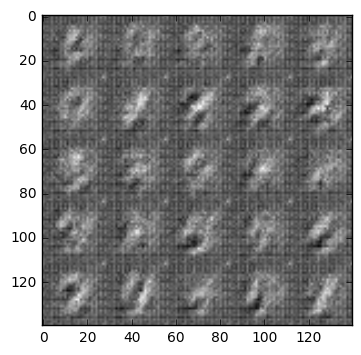

Epoch 1/2... Discriminator Loss: 1.1621... Generator Loss: 0.7847
Epoch 1/2... Discriminator Loss: 1.3760... Generator Loss: 0.4777
Epoch 1/2... Discriminator Loss: 1.1550... Generator Loss: 0.7420
Epoch 1/2... Discriminator Loss: 1.1665... Generator Loss: 0.9754
Epoch 1/2... Discriminator Loss: 1.2280... Generator Loss: 1.0391
Epoch 1/2... Discriminator Loss: 1.3630... Generator Loss: 1.0831
Epoch 1/2... Discriminator Loss: 1.2551... Generator Loss: 1.0625
Epoch 1/2... Discriminator Loss: 1.3910... Generator Loss: 0.9841
Epoch 1/2... Discriminator Loss: 1.3075... Generator Loss: 0.9406
Epoch 1/2... Discriminator Loss: 1.2370... Generator Loss: 1.1102


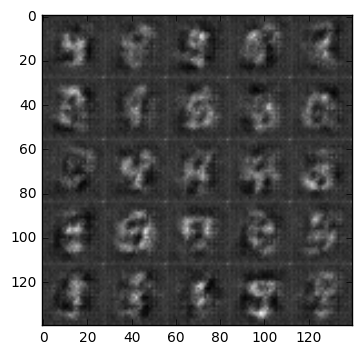

Epoch 1/2... Discriminator Loss: 1.1473... Generator Loss: 1.0755
Epoch 1/2... Discriminator Loss: 1.2225... Generator Loss: 0.6818
Epoch 1/2... Discriminator Loss: 1.2038... Generator Loss: 0.8291
Epoch 1/2... Discriminator Loss: 1.3829... Generator Loss: 0.4566
Epoch 1/2... Discriminator Loss: 1.1613... Generator Loss: 0.6605
Epoch 1/2... Discriminator Loss: 1.2192... Generator Loss: 0.5996
Epoch 1/2... Discriminator Loss: 1.2053... Generator Loss: 0.6459
Epoch 1/2... Discriminator Loss: 1.3308... Generator Loss: 0.4905
Epoch 1/2... Discriminator Loss: 1.1058... Generator Loss: 0.7467
Epoch 1/2... Discriminator Loss: 1.2179... Generator Loss: 0.5855


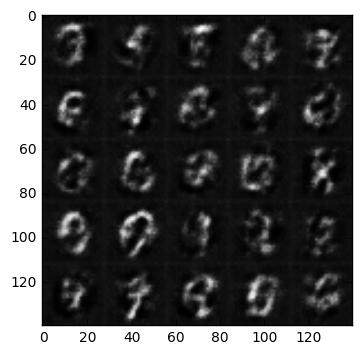

Epoch 1/2... Discriminator Loss: 1.1425... Generator Loss: 1.1154
Epoch 1/2... Discriminator Loss: 1.5366... Generator Loss: 0.3826
Epoch 1/2... Discriminator Loss: 1.1359... Generator Loss: 0.8295
Epoch 1/2... Discriminator Loss: 1.0995... Generator Loss: 1.0205
Epoch 1/2... Discriminator Loss: 1.0616... Generator Loss: 1.0976
Epoch 1/2... Discriminator Loss: 1.1774... Generator Loss: 0.6221
Epoch 1/2... Discriminator Loss: 1.2577... Generator Loss: 0.5433
Epoch 1/2... Discriminator Loss: 1.0531... Generator Loss: 0.7878
Epoch 1/2... Discriminator Loss: 1.6445... Generator Loss: 0.3558
Epoch 1/2... Discriminator Loss: 1.2993... Generator Loss: 0.5110


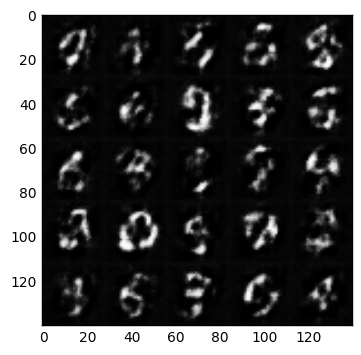

Epoch 1/2... Discriminator Loss: 1.1288... Generator Loss: 0.6740
Epoch 1/2... Discriminator Loss: 1.1476... Generator Loss: 0.6507
Epoch 1/2... Discriminator Loss: 1.1801... Generator Loss: 0.6444
Epoch 1/2... Discriminator Loss: 1.1562... Generator Loss: 0.6630
Epoch 1/2... Discriminator Loss: 1.0440... Generator Loss: 1.2067
Epoch 1/2... Discriminator Loss: 1.0939... Generator Loss: 1.2781
Epoch 1/2... Discriminator Loss: 1.1719... Generator Loss: 1.2489
Epoch 1/2... Discriminator Loss: 1.0535... Generator Loss: 0.8139
Epoch 1/2... Discriminator Loss: 1.1341... Generator Loss: 0.6774
Epoch 1/2... Discriminator Loss: 1.1073... Generator Loss: 0.6953


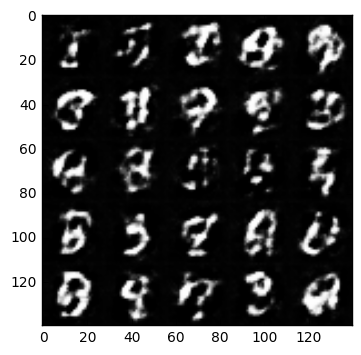

Epoch 1/2... Discriminator Loss: 1.3231... Generator Loss: 0.5013
Epoch 1/2... Discriminator Loss: 1.1795... Generator Loss: 0.6056
Epoch 1/2... Discriminator Loss: 1.0680... Generator Loss: 1.0943
Epoch 1/2... Discriminator Loss: 0.9739... Generator Loss: 1.0090
Epoch 1/2... Discriminator Loss: 1.0312... Generator Loss: 0.9771
Epoch 1/2... Discriminator Loss: 1.1305... Generator Loss: 1.1478
Epoch 1/2... Discriminator Loss: 1.6969... Generator Loss: 0.3352
Epoch 1/2... Discriminator Loss: 1.1246... Generator Loss: 0.6710
Epoch 1/2... Discriminator Loss: 1.3627... Generator Loss: 0.4729
Epoch 1/2... Discriminator Loss: 1.0200... Generator Loss: 0.8694


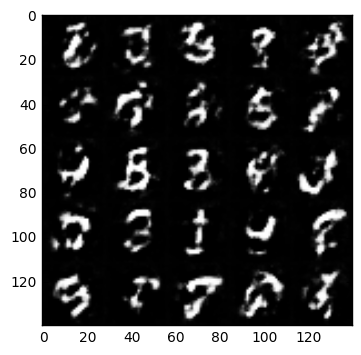

Epoch 1/2... Discriminator Loss: 1.0736... Generator Loss: 0.7692
Epoch 1/2... Discriminator Loss: 1.1085... Generator Loss: 1.3631
Epoch 1/2... Discriminator Loss: 1.1074... Generator Loss: 0.7846
Epoch 1/2... Discriminator Loss: 1.0157... Generator Loss: 0.9270
Epoch 1/2... Discriminator Loss: 1.2885... Generator Loss: 0.5262
Epoch 1/2... Discriminator Loss: 1.1748... Generator Loss: 0.6488
Epoch 1/2... Discriminator Loss: 1.0911... Generator Loss: 1.1717
Epoch 1/2... Discriminator Loss: 1.1253... Generator Loss: 0.9070
Epoch 1/2... Discriminator Loss: 1.0904... Generator Loss: 0.7448
Epoch 1/2... Discriminator Loss: 1.0872... Generator Loss: 0.8515


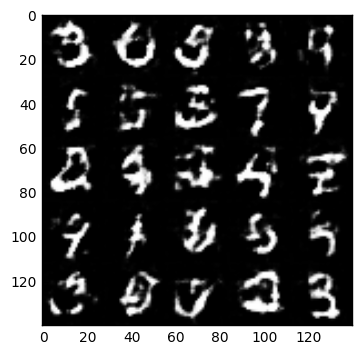

Epoch 1/2... Discriminator Loss: 1.1842... Generator Loss: 0.6384
Epoch 1/2... Discriminator Loss: 1.2799... Generator Loss: 0.5405
Epoch 1/2... Discriminator Loss: 1.2414... Generator Loss: 0.5644
Epoch 1/2... Discriminator Loss: 1.0408... Generator Loss: 1.3029
Epoch 1/2... Discriminator Loss: 1.1738... Generator Loss: 1.2743
Epoch 1/2... Discriminator Loss: 1.0357... Generator Loss: 0.8997
Epoch 1/2... Discriminator Loss: 1.1622... Generator Loss: 0.6462
Epoch 1/2... Discriminator Loss: 1.6573... Generator Loss: 0.3506
Epoch 1/2... Discriminator Loss: 1.4575... Generator Loss: 0.4165
Epoch 1/2... Discriminator Loss: 1.2012... Generator Loss: 0.6514


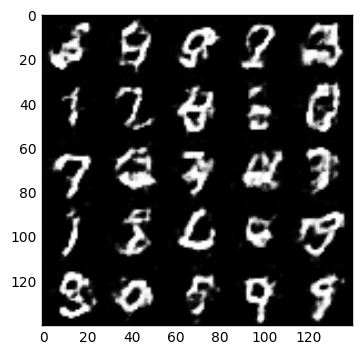

Epoch 1/2... Discriminator Loss: 1.0768... Generator Loss: 0.7775
Epoch 1/2... Discriminator Loss: 1.1298... Generator Loss: 0.7025
Epoch 1/2... Discriminator Loss: 1.1514... Generator Loss: 0.6489
Epoch 1/2... Discriminator Loss: 1.0676... Generator Loss: 0.7587
Epoch 1/2... Discriminator Loss: 1.2648... Generator Loss: 0.5445
Epoch 1/2... Discriminator Loss: 2.5886... Generator Loss: 0.2049
Epoch 1/2... Discriminator Loss: 1.4467... Generator Loss: 0.9869
Epoch 1/2... Discriminator Loss: 1.1969... Generator Loss: 0.9694
Epoch 1/2... Discriminator Loss: 1.1137... Generator Loss: 0.8904
Epoch 1/2... Discriminator Loss: 1.1437... Generator Loss: 0.7145


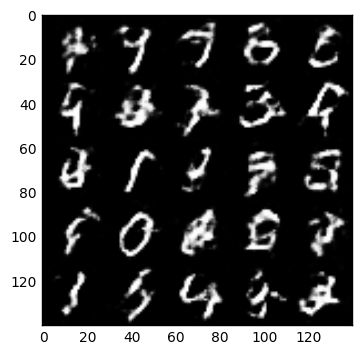

Epoch 1/2... Discriminator Loss: 1.1382... Generator Loss: 0.9030
Epoch 1/2... Discriminator Loss: 1.1656... Generator Loss: 0.6830
Epoch 1/2... Discriminator Loss: 1.2927... Generator Loss: 0.5281
Epoch 2/2... Discriminator Loss: 1.4245... Generator Loss: 0.4446
Epoch 2/2... Discriminator Loss: 1.3738... Generator Loss: 0.4805
Epoch 2/2... Discriminator Loss: 1.3197... Generator Loss: 0.5309
Epoch 2/2... Discriminator Loss: 1.2763... Generator Loss: 0.5381
Epoch 2/2... Discriminator Loss: 1.1658... Generator Loss: 0.8712
Epoch 2/2... Discriminator Loss: 1.4143... Generator Loss: 0.4552
Epoch 2/2... Discriminator Loss: 1.3069... Generator Loss: 0.5210
Epoch 2/2... Discriminator Loss: 1.1260... Generator Loss: 0.7124
Epoch 2/2... Discriminator Loss: 1.1061... Generator Loss: 0.7935
Epoch 2/2... Discriminator Loss: 1.3504... Generator Loss: 0.4804


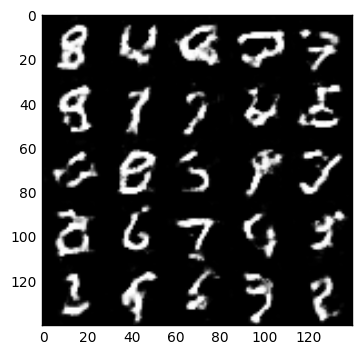

Epoch 2/2... Discriminator Loss: 1.2328... Generator Loss: 0.5775
Epoch 2/2... Discriminator Loss: 1.1553... Generator Loss: 0.6577
Epoch 2/2... Discriminator Loss: 1.0971... Generator Loss: 0.8107
Epoch 2/2... Discriminator Loss: 1.2283... Generator Loss: 1.1479
Epoch 2/2... Discriminator Loss: 1.1128... Generator Loss: 0.8643
Epoch 2/2... Discriminator Loss: 1.1765... Generator Loss: 1.0112
Epoch 2/2... Discriminator Loss: 1.2710... Generator Loss: 1.0241
Epoch 2/2... Discriminator Loss: 1.1838... Generator Loss: 0.9809
Epoch 2/2... Discriminator Loss: 1.1307... Generator Loss: 0.8616
Epoch 2/2... Discriminator Loss: 1.1411... Generator Loss: 1.0575


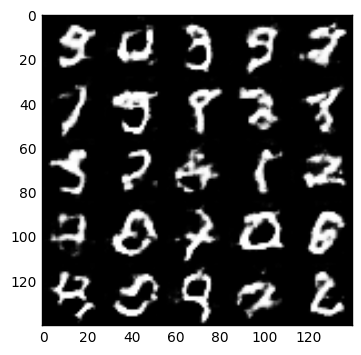

Epoch 2/2... Discriminator Loss: 1.0768... Generator Loss: 1.2378
Epoch 2/2... Discriminator Loss: 1.4457... Generator Loss: 0.4331
Epoch 2/2... Discriminator Loss: 1.1989... Generator Loss: 0.6439
Epoch 2/2... Discriminator Loss: 1.6676... Generator Loss: 0.3433
Epoch 2/2... Discriminator Loss: 1.1435... Generator Loss: 0.6644
Epoch 2/2... Discriminator Loss: 1.1810... Generator Loss: 1.0384
Epoch 2/2... Discriminator Loss: 1.1382... Generator Loss: 1.0166
Epoch 2/2... Discriminator Loss: 1.2400... Generator Loss: 1.0063
Epoch 2/2... Discriminator Loss: 1.1695... Generator Loss: 0.7173
Epoch 2/2... Discriminator Loss: 1.0937... Generator Loss: 0.9372


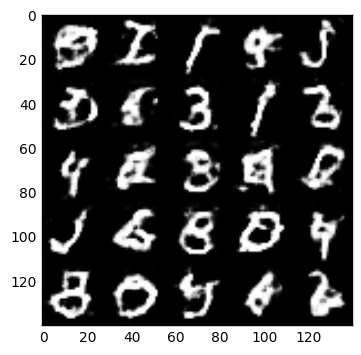

Epoch 2/2... Discriminator Loss: 1.1178... Generator Loss: 0.7386
Epoch 2/2... Discriminator Loss: 1.3379... Generator Loss: 0.4967
Epoch 2/2... Discriminator Loss: 1.0513... Generator Loss: 0.9226
Epoch 2/2... Discriminator Loss: 1.0853... Generator Loss: 0.8345
Epoch 2/2... Discriminator Loss: 1.0338... Generator Loss: 0.8283
Epoch 2/2... Discriminator Loss: 1.1235... Generator Loss: 0.6854
Epoch 2/2... Discriminator Loss: 1.1340... Generator Loss: 0.6725
Epoch 2/2... Discriminator Loss: 1.1643... Generator Loss: 1.4365
Epoch 2/2... Discriminator Loss: 1.2858... Generator Loss: 0.5413
Epoch 2/2... Discriminator Loss: 1.0559... Generator Loss: 0.9528


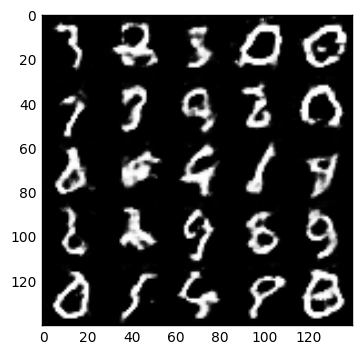

Epoch 2/2... Discriminator Loss: 1.0821... Generator Loss: 0.8434
Epoch 2/2... Discriminator Loss: 1.1218... Generator Loss: 0.6792
Epoch 2/2... Discriminator Loss: 1.0612... Generator Loss: 0.8030
Epoch 2/2... Discriminator Loss: 1.0453... Generator Loss: 0.9336
Epoch 2/2... Discriminator Loss: 1.0931... Generator Loss: 1.1705
Epoch 2/2... Discriminator Loss: 1.0992... Generator Loss: 0.7584
Epoch 2/2... Discriminator Loss: 1.3412... Generator Loss: 0.5016
Epoch 2/2... Discriminator Loss: 1.1001... Generator Loss: 0.7646
Epoch 2/2... Discriminator Loss: 1.1135... Generator Loss: 1.1350
Epoch 2/2... Discriminator Loss: 1.0720... Generator Loss: 1.0614


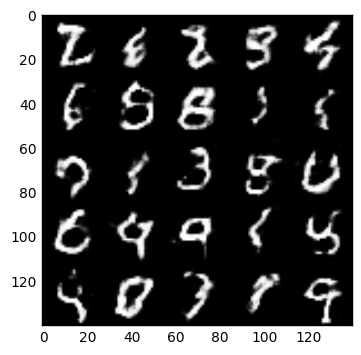

Epoch 2/2... Discriminator Loss: 1.2470... Generator Loss: 0.5731
Epoch 2/2... Discriminator Loss: 1.3060... Generator Loss: 0.5138
Epoch 2/2... Discriminator Loss: 1.4756... Generator Loss: 1.6042
Epoch 2/2... Discriminator Loss: 1.0620... Generator Loss: 0.9156
Epoch 2/2... Discriminator Loss: 1.0295... Generator Loss: 1.1672
Epoch 2/2... Discriminator Loss: 1.1545... Generator Loss: 0.6897
Epoch 2/2... Discriminator Loss: 1.4154... Generator Loss: 0.4556
Epoch 2/2... Discriminator Loss: 1.0206... Generator Loss: 0.8598
Epoch 2/2... Discriminator Loss: 0.9978... Generator Loss: 0.8436
Epoch 2/2... Discriminator Loss: 0.9818... Generator Loss: 1.1135


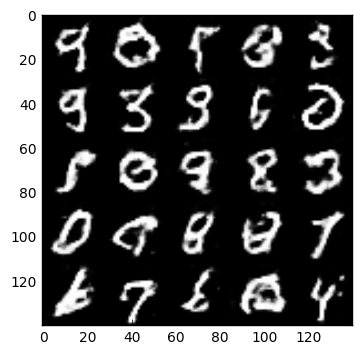

Epoch 2/2... Discriminator Loss: 1.2513... Generator Loss: 1.1590
Epoch 2/2... Discriminator Loss: 1.0015... Generator Loss: 0.9069
Epoch 2/2... Discriminator Loss: 1.1228... Generator Loss: 0.6707
Epoch 2/2... Discriminator Loss: 0.9947... Generator Loss: 0.8991
Epoch 2/2... Discriminator Loss: 1.1961... Generator Loss: 0.6114
Epoch 2/2... Discriminator Loss: 1.2180... Generator Loss: 0.5947
Epoch 2/2... Discriminator Loss: 1.0005... Generator Loss: 0.9762
Epoch 2/2... Discriminator Loss: 1.8863... Generator Loss: 0.2933
Epoch 2/2... Discriminator Loss: 1.0454... Generator Loss: 0.8814
Epoch 2/2... Discriminator Loss: 1.0761... Generator Loss: 0.8049


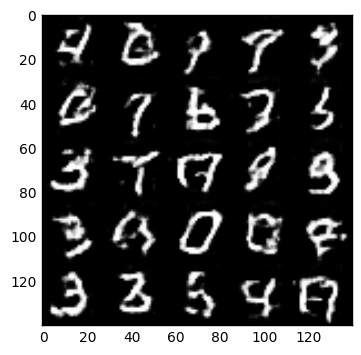

Epoch 2/2... Discriminator Loss: 1.3615... Generator Loss: 0.5418
Epoch 2/2... Discriminator Loss: 1.1000... Generator Loss: 0.7140
Epoch 2/2... Discriminator Loss: 0.9920... Generator Loss: 1.0844
Epoch 2/2... Discriminator Loss: 0.9565... Generator Loss: 1.0506
Epoch 2/2... Discriminator Loss: 1.0427... Generator Loss: 0.8275
Epoch 2/2... Discriminator Loss: 1.0830... Generator Loss: 0.7261
Epoch 2/2... Discriminator Loss: 1.0228... Generator Loss: 0.9393
Epoch 2/2... Discriminator Loss: 1.2148... Generator Loss: 0.5843
Epoch 2/2... Discriminator Loss: 1.0875... Generator Loss: 0.7888
Epoch 2/2... Discriminator Loss: 1.1836... Generator Loss: 0.6278


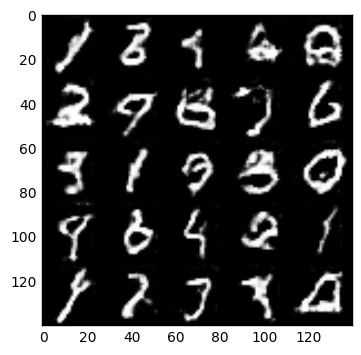

Epoch 2/2... Discriminator Loss: 1.0757... Generator Loss: 0.7774
Epoch 2/2... Discriminator Loss: 1.0104... Generator Loss: 1.1272
Epoch 2/2... Discriminator Loss: 0.9880... Generator Loss: 1.0032
Epoch 2/2... Discriminator Loss: 1.6689... Generator Loss: 0.3947
Epoch 2/2... Discriminator Loss: 1.0216... Generator Loss: 0.8309
Epoch 2/2... Discriminator Loss: 2.6968... Generator Loss: 0.2007
Epoch 2/2... Discriminator Loss: 1.4367... Generator Loss: 0.7933
Epoch 2/2... Discriminator Loss: 1.0745... Generator Loss: 0.8210
Epoch 2/2... Discriminator Loss: 1.0399... Generator Loss: 0.8075
Epoch 2/2... Discriminator Loss: 1.0441... Generator Loss: 0.7907


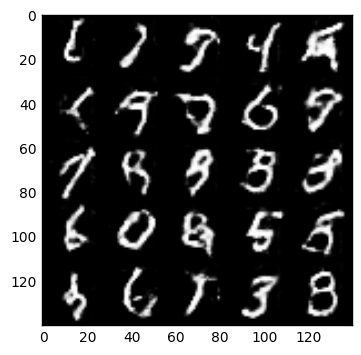

Epoch 2/2... Discriminator Loss: 1.1348... Generator Loss: 0.6504
Epoch 2/2... Discriminator Loss: 1.0858... Generator Loss: 0.9133
Epoch 2/2... Discriminator Loss: 1.1717... Generator Loss: 0.6504


In [11]:
batch_size = 64
z_dim = 128
learning_rate = 1e-04
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.0554... Generator Loss: 2.3077
Epoch 1/1... Discriminator Loss: 0.9230... Generator Loss: 1.1022
Epoch 1/1... Discriminator Loss: 1.0906... Generator Loss: 6.3143
Epoch 1/1... Discriminator Loss: 1.2340... Generator Loss: 0.9240
Epoch 1/1... Discriminator Loss: 1.3761... Generator Loss: 3.4735
Epoch 1/1... Discriminator Loss: 1.0818... Generator Loss: 2.4371
Epoch 1/1... Discriminator Loss: 0.7764... Generator Loss: 2.8107
Epoch 1/1... Discriminator Loss: 1.0805... Generator Loss: 0.7872
Epoch 1/1... Discriminator Loss: 0.9911... Generator Loss: 1.2360
Epoch 1/1... Discriminator Loss: 0.8948... Generator Loss: 2.4946


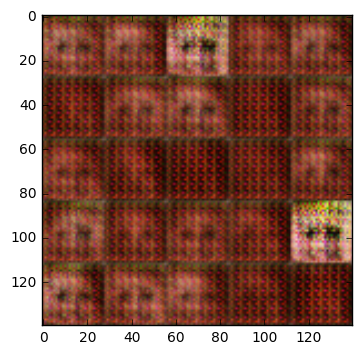

Epoch 1/1... Discriminator Loss: 1.0878... Generator Loss: 2.6857
Epoch 1/1... Discriminator Loss: 1.1404... Generator Loss: 1.5695
Epoch 1/1... Discriminator Loss: 1.1762... Generator Loss: 0.8078
Epoch 1/1... Discriminator Loss: 1.6406... Generator Loss: 0.3725
Epoch 1/1... Discriminator Loss: 1.2271... Generator Loss: 0.6846
Epoch 1/1... Discriminator Loss: 1.3737... Generator Loss: 1.2151
Epoch 1/1... Discriminator Loss: 1.6148... Generator Loss: 1.3156
Epoch 1/1... Discriminator Loss: 1.7061... Generator Loss: 0.3313
Epoch 1/1... Discriminator Loss: 1.4553... Generator Loss: 1.3896
Epoch 1/1... Discriminator Loss: 1.1951... Generator Loss: 0.7531


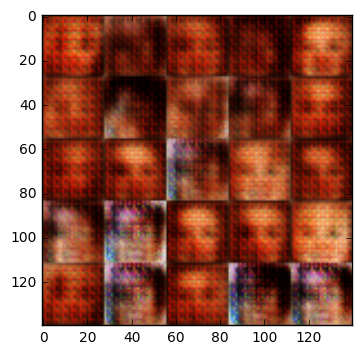

Epoch 1/1... Discriminator Loss: 1.5378... Generator Loss: 0.4155
Epoch 1/1... Discriminator Loss: 1.4240... Generator Loss: 1.0577
Epoch 1/1... Discriminator Loss: 1.0708... Generator Loss: 1.2117
Epoch 1/1... Discriminator Loss: 1.3387... Generator Loss: 0.8447
Epoch 1/1... Discriminator Loss: 1.6838... Generator Loss: 0.3737
Epoch 1/1... Discriminator Loss: 1.3749... Generator Loss: 0.5314
Epoch 1/1... Discriminator Loss: 1.4716... Generator Loss: 0.4664
Epoch 1/1... Discriminator Loss: 1.1459... Generator Loss: 0.7649
Epoch 1/1... Discriminator Loss: 1.0111... Generator Loss: 1.1330
Epoch 1/1... Discriminator Loss: 1.2926... Generator Loss: 0.5766


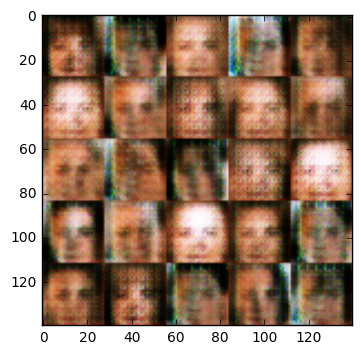

Epoch 1/1... Discriminator Loss: 1.5205... Generator Loss: 1.5955
Epoch 1/1... Discriminator Loss: 1.6643... Generator Loss: 1.1696
Epoch 1/1... Discriminator Loss: 1.3612... Generator Loss: 0.5623
Epoch 1/1... Discriminator Loss: 1.5079... Generator Loss: 0.4428
Epoch 1/1... Discriminator Loss: 1.4108... Generator Loss: 1.2894
Epoch 1/1... Discriminator Loss: 1.4910... Generator Loss: 0.5280
Epoch 1/1... Discriminator Loss: 1.6135... Generator Loss: 0.3778
Epoch 1/1... Discriminator Loss: 1.2234... Generator Loss: 1.0329
Epoch 1/1... Discriminator Loss: 1.3523... Generator Loss: 0.7863
Epoch 1/1... Discriminator Loss: 1.2576... Generator Loss: 0.8348


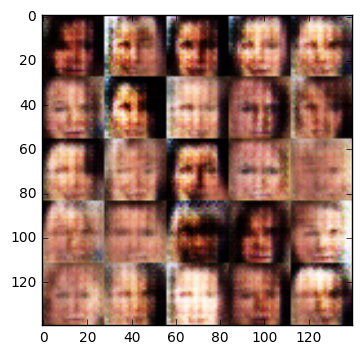

Epoch 1/1... Discriminator Loss: 1.1965... Generator Loss: 0.9892
Epoch 1/1... Discriminator Loss: 1.4688... Generator Loss: 1.3488
Epoch 1/1... Discriminator Loss: 1.4057... Generator Loss: 0.5682
Epoch 1/1... Discriminator Loss: 1.4201... Generator Loss: 0.6457
Epoch 1/1... Discriminator Loss: 1.5449... Generator Loss: 0.4694
Epoch 1/1... Discriminator Loss: 1.2886... Generator Loss: 0.6883
Epoch 1/1... Discriminator Loss: 1.2734... Generator Loss: 0.7305
Epoch 1/1... Discriminator Loss: 2.1166... Generator Loss: 1.7513
Epoch 1/1... Discriminator Loss: 1.5029... Generator Loss: 0.7970
Epoch 1/1... Discriminator Loss: 1.2955... Generator Loss: 0.7306


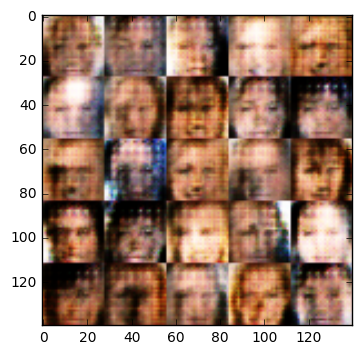

Epoch 1/1... Discriminator Loss: 1.5753... Generator Loss: 1.3003
Epoch 1/1... Discriminator Loss: 1.2866... Generator Loss: 0.9066
Epoch 1/1... Discriminator Loss: 1.2327... Generator Loss: 0.8538
Epoch 1/1... Discriminator Loss: 1.4962... Generator Loss: 1.2627
Epoch 1/1... Discriminator Loss: 1.3502... Generator Loss: 0.5752
Epoch 1/1... Discriminator Loss: 1.3468... Generator Loss: 0.5347
Epoch 1/1... Discriminator Loss: 1.4505... Generator Loss: 0.4976
Epoch 1/1... Discriminator Loss: 1.3231... Generator Loss: 0.6419
Epoch 1/1... Discriminator Loss: 1.4344... Generator Loss: 1.0095
Epoch 1/1... Discriminator Loss: 1.3063... Generator Loss: 0.6461


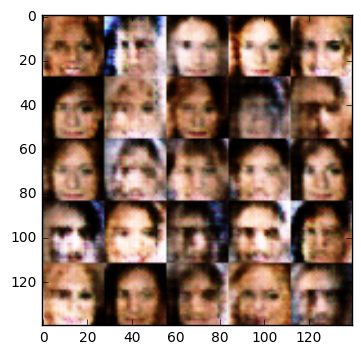

Epoch 1/1... Discriminator Loss: 1.4944... Generator Loss: 0.4783
Epoch 1/1... Discriminator Loss: 1.2894... Generator Loss: 0.9767
Epoch 1/1... Discriminator Loss: 1.2789... Generator Loss: 0.6520
Epoch 1/1... Discriminator Loss: 1.3987... Generator Loss: 0.6510
Epoch 1/1... Discriminator Loss: 1.3248... Generator Loss: 0.6046
Epoch 1/1... Discriminator Loss: 1.5301... Generator Loss: 1.3061
Epoch 1/1... Discriminator Loss: 1.4122... Generator Loss: 0.6168
Epoch 1/1... Discriminator Loss: 1.3114... Generator Loss: 0.7088
Epoch 1/1... Discriminator Loss: 1.4693... Generator Loss: 0.5450
Epoch 1/1... Discriminator Loss: 1.4131... Generator Loss: 0.5666


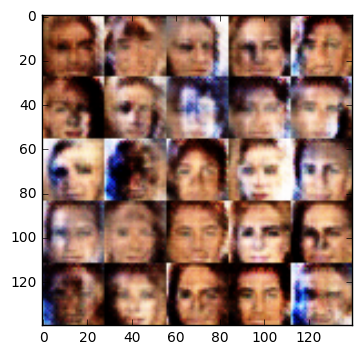

Epoch 1/1... Discriminator Loss: 1.2907... Generator Loss: 0.6474
Epoch 1/1... Discriminator Loss: 1.5275... Generator Loss: 0.4291
Epoch 1/1... Discriminator Loss: 1.4693... Generator Loss: 0.4833
Epoch 1/1... Discriminator Loss: 1.5065... Generator Loss: 0.4903
Epoch 1/1... Discriminator Loss: 1.3358... Generator Loss: 0.7206
Epoch 1/1... Discriminator Loss: 1.3290... Generator Loss: 0.7729
Epoch 1/1... Discriminator Loss: 1.4668... Generator Loss: 0.9385
Epoch 1/1... Discriminator Loss: 1.5649... Generator Loss: 0.3942
Epoch 1/1... Discriminator Loss: 1.4818... Generator Loss: 0.9566
Epoch 1/1... Discriminator Loss: 1.4278... Generator Loss: 0.5126


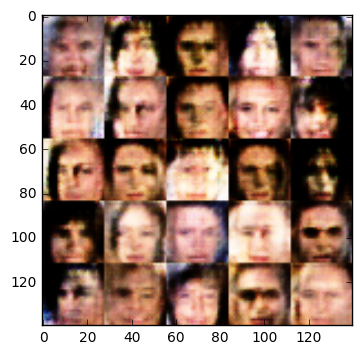

Epoch 1/1... Discriminator Loss: 1.2111... Generator Loss: 0.9175
Epoch 1/1... Discriminator Loss: 1.6156... Generator Loss: 1.3130
Epoch 1/1... Discriminator Loss: 1.4003... Generator Loss: 0.5711
Epoch 1/1... Discriminator Loss: 1.3531... Generator Loss: 1.2586
Epoch 1/1... Discriminator Loss: 1.2153... Generator Loss: 0.7111
Epoch 1/1... Discriminator Loss: 1.3225... Generator Loss: 0.7197
Epoch 1/1... Discriminator Loss: 1.4183... Generator Loss: 1.0621
Epoch 1/1... Discriminator Loss: 1.3107... Generator Loss: 0.5910
Epoch 1/1... Discriminator Loss: 1.4036... Generator Loss: 1.1158
Epoch 1/1... Discriminator Loss: 1.8090... Generator Loss: 0.2977


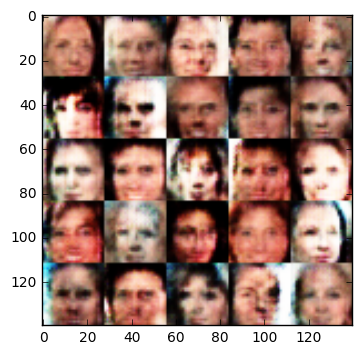

Epoch 1/1... Discriminator Loss: 1.3072... Generator Loss: 0.7536
Epoch 1/1... Discriminator Loss: 1.2983... Generator Loss: 1.0508
Epoch 1/1... Discriminator Loss: 1.3182... Generator Loss: 0.8279
Epoch 1/1... Discriminator Loss: 1.3354... Generator Loss: 0.7389
Epoch 1/1... Discriminator Loss: 1.5461... Generator Loss: 1.2801
Epoch 1/1... Discriminator Loss: 1.2952... Generator Loss: 0.6258
Epoch 1/1... Discriminator Loss: 1.5828... Generator Loss: 1.0834
Epoch 1/1... Discriminator Loss: 1.6371... Generator Loss: 0.3620
Epoch 1/1... Discriminator Loss: 1.3084... Generator Loss: 0.7306
Epoch 1/1... Discriminator Loss: 1.3449... Generator Loss: 0.5329


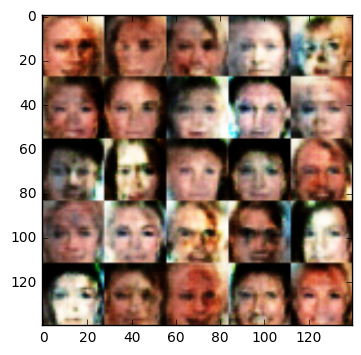

Epoch 1/1... Discriminator Loss: 1.9877... Generator Loss: 0.2686
Epoch 1/1... Discriminator Loss: 1.3682... Generator Loss: 0.9368
Epoch 1/1... Discriminator Loss: 1.4164... Generator Loss: 0.4866
Epoch 1/1... Discriminator Loss: 1.3007... Generator Loss: 1.0191
Epoch 1/1... Discriminator Loss: 1.3265... Generator Loss: 0.7785
Epoch 1/1... Discriminator Loss: 1.4219... Generator Loss: 0.4757
Epoch 1/1... Discriminator Loss: 1.2998... Generator Loss: 0.8707
Epoch 1/1... Discriminator Loss: 1.3392... Generator Loss: 0.5278
Epoch 1/1... Discriminator Loss: 1.5389... Generator Loss: 0.4087
Epoch 1/1... Discriminator Loss: 1.2563... Generator Loss: 0.7794


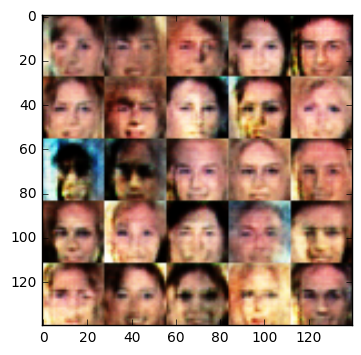

Epoch 1/1... Discriminator Loss: 1.4318... Generator Loss: 0.4838
Epoch 1/1... Discriminator Loss: 1.4956... Generator Loss: 0.4980
Epoch 1/1... Discriminator Loss: 1.2331... Generator Loss: 0.6770
Epoch 1/1... Discriminator Loss: 1.4734... Generator Loss: 0.4371
Epoch 1/1... Discriminator Loss: 1.2139... Generator Loss: 0.7020
Epoch 1/1... Discriminator Loss: 1.3218... Generator Loss: 0.5980
Epoch 1/1... Discriminator Loss: 1.2449... Generator Loss: 0.8838
Epoch 1/1... Discriminator Loss: 1.3781... Generator Loss: 0.5408
Epoch 1/1... Discriminator Loss: 1.3775... Generator Loss: 0.5020
Epoch 1/1... Discriminator Loss: 1.2528... Generator Loss: 0.5944


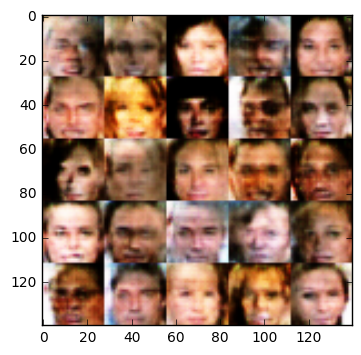

Epoch 1/1... Discriminator Loss: 1.2308... Generator Loss: 0.6637
Epoch 1/1... Discriminator Loss: 1.2985... Generator Loss: 0.5490
Epoch 1/1... Discriminator Loss: 1.1269... Generator Loss: 1.0300
Epoch 1/1... Discriminator Loss: 1.5357... Generator Loss: 0.9445
Epoch 1/1... Discriminator Loss: 1.0623... Generator Loss: 0.8756
Epoch 1/1... Discriminator Loss: 1.3719... Generator Loss: 0.5009
Epoch 1/1... Discriminator Loss: 1.4117... Generator Loss: 0.8713
Epoch 1/1... Discriminator Loss: 1.2977... Generator Loss: 0.9231
Epoch 1/1... Discriminator Loss: 1.5655... Generator Loss: 0.3804
Epoch 1/1... Discriminator Loss: 1.4759... Generator Loss: 0.4758


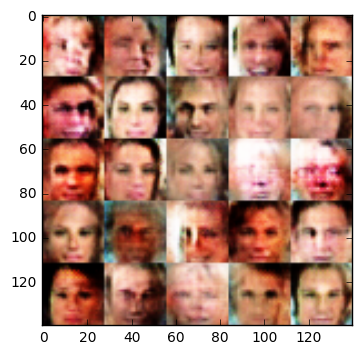

Epoch 1/1... Discriminator Loss: 1.0301... Generator Loss: 0.8830
Epoch 1/1... Discriminator Loss: 1.2161... Generator Loss: 0.9404
Epoch 1/1... Discriminator Loss: 1.1812... Generator Loss: 0.8633
Epoch 1/1... Discriminator Loss: 1.0915... Generator Loss: 0.7809
Epoch 1/1... Discriminator Loss: 1.5011... Generator Loss: 1.0469
Epoch 1/1... Discriminator Loss: 1.2665... Generator Loss: 1.2468
Epoch 1/1... Discriminator Loss: 1.4293... Generator Loss: 0.4672
Epoch 1/1... Discriminator Loss: 1.2784... Generator Loss: 0.9766
Epoch 1/1... Discriminator Loss: 1.5678... Generator Loss: 0.3858
Epoch 1/1... Discriminator Loss: 1.6336... Generator Loss: 0.3556


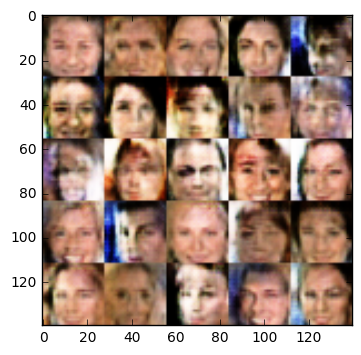

Epoch 1/1... Discriminator Loss: 1.2948... Generator Loss: 0.8860
Epoch 1/1... Discriminator Loss: 1.4048... Generator Loss: 0.8888
Epoch 1/1... Discriminator Loss: 1.0950... Generator Loss: 0.9676
Epoch 1/1... Discriminator Loss: 1.4815... Generator Loss: 0.9111
Epoch 1/1... Discriminator Loss: 1.1570... Generator Loss: 1.3177
Epoch 1/1... Discriminator Loss: 1.3760... Generator Loss: 1.0456
Epoch 1/1... Discriminator Loss: 1.1610... Generator Loss: 0.7044
Epoch 1/1... Discriminator Loss: 1.0323... Generator Loss: 1.2016
Epoch 1/1... Discriminator Loss: 1.4360... Generator Loss: 0.4461
Epoch 1/1... Discriminator Loss: 1.4169... Generator Loss: 0.9148


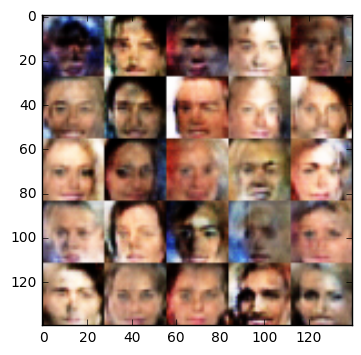

Epoch 1/1... Discriminator Loss: 1.7081... Generator Loss: 0.3298
Epoch 1/1... Discriminator Loss: 1.2598... Generator Loss: 1.2503
Epoch 1/1... Discriminator Loss: 1.2495... Generator Loss: 0.5864
Epoch 1/1... Discriminator Loss: 1.2594... Generator Loss: 0.5891
Epoch 1/1... Discriminator Loss: 0.9433... Generator Loss: 1.2659
Epoch 1/1... Discriminator Loss: 1.1726... Generator Loss: 0.7412
Epoch 1/1... Discriminator Loss: 1.5348... Generator Loss: 0.3892
Epoch 1/1... Discriminator Loss: 1.1436... Generator Loss: 0.8379
Epoch 1/1... Discriminator Loss: 1.0509... Generator Loss: 0.9257
Epoch 1/1... Discriminator Loss: 1.1234... Generator Loss: 1.3746


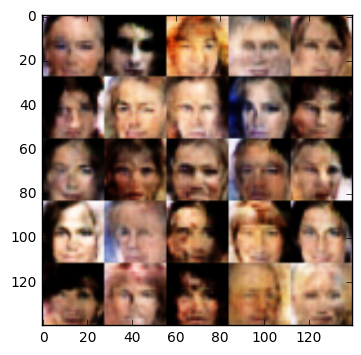

Epoch 1/1... Discriminator Loss: 1.7809... Generator Loss: 1.1184
Epoch 1/1... Discriminator Loss: 1.4499... Generator Loss: 0.4518
Epoch 1/1... Discriminator Loss: 1.1495... Generator Loss: 0.6736
Epoch 1/1... Discriminator Loss: 1.3842... Generator Loss: 0.4802
Epoch 1/1... Discriminator Loss: 1.5612... Generator Loss: 0.3804
Epoch 1/1... Discriminator Loss: 1.2554... Generator Loss: 1.3215
Epoch 1/1... Discriminator Loss: 1.1973... Generator Loss: 0.6761
Epoch 1/1... Discriminator Loss: 1.0669... Generator Loss: 1.1028
Epoch 1/1... Discriminator Loss: 1.2782... Generator Loss: 0.5514
Epoch 1/1... Discriminator Loss: 1.2151... Generator Loss: 1.3090


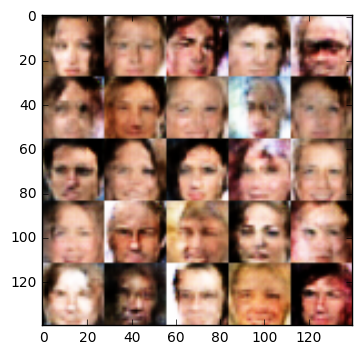

Epoch 1/1... Discriminator Loss: 1.0264... Generator Loss: 1.0956
Epoch 1/1... Discriminator Loss: 0.9916... Generator Loss: 0.9159
Epoch 1/1... Discriminator Loss: 1.3702... Generator Loss: 0.9059
Epoch 1/1... Discriminator Loss: 1.1415... Generator Loss: 0.9254
Epoch 1/1... Discriminator Loss: 1.0709... Generator Loss: 0.8457
Epoch 1/1... Discriminator Loss: 1.7055... Generator Loss: 0.3310
Epoch 1/1... Discriminator Loss: 1.3664... Generator Loss: 0.7892
Epoch 1/1... Discriminator Loss: 1.0000... Generator Loss: 1.0519
Epoch 1/1... Discriminator Loss: 1.0758... Generator Loss: 1.3179
Epoch 1/1... Discriminator Loss: 1.5276... Generator Loss: 1.0742


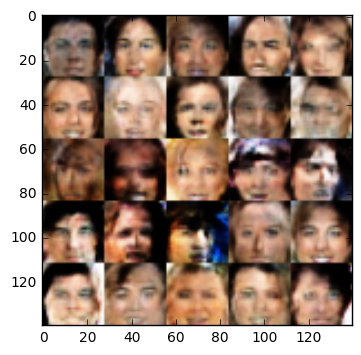

Epoch 1/1... Discriminator Loss: 1.0807... Generator Loss: 1.2865
Epoch 1/1... Discriminator Loss: 1.1177... Generator Loss: 0.9192
Epoch 1/1... Discriminator Loss: 1.1846... Generator Loss: 0.6877
Epoch 1/1... Discriminator Loss: 1.5603... Generator Loss: 1.0481
Epoch 1/1... Discriminator Loss: 1.1980... Generator Loss: 0.7678
Epoch 1/1... Discriminator Loss: 1.0411... Generator Loss: 0.7955
Epoch 1/1... Discriminator Loss: 0.9789... Generator Loss: 0.9158
Epoch 1/1... Discriminator Loss: 1.3442... Generator Loss: 0.8456
Epoch 1/1... Discriminator Loss: 1.0353... Generator Loss: 1.2169
Epoch 1/1... Discriminator Loss: 1.1107... Generator Loss: 1.2580


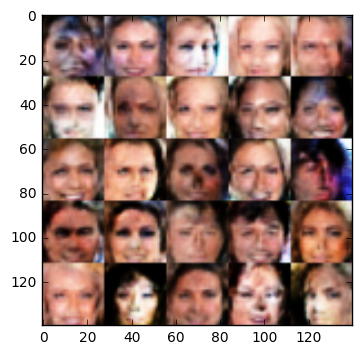

Epoch 1/1... Discriminator Loss: 1.1383... Generator Loss: 1.0041
Epoch 1/1... Discriminator Loss: 1.4769... Generator Loss: 0.4520
Epoch 1/1... Discriminator Loss: 1.3014... Generator Loss: 0.5475
Epoch 1/1... Discriminator Loss: 1.1640... Generator Loss: 0.9082
Epoch 1/1... Discriminator Loss: 1.0445... Generator Loss: 0.8579
Epoch 1/1... Discriminator Loss: 1.9138... Generator Loss: 0.2729
Epoch 1/1... Discriminator Loss: 1.3594... Generator Loss: 0.5311
Epoch 1/1... Discriminator Loss: 1.2833... Generator Loss: 1.0315
Epoch 1/1... Discriminator Loss: 0.9848... Generator Loss: 1.0628
Epoch 1/1... Discriminator Loss: 1.7365... Generator Loss: 1.5663


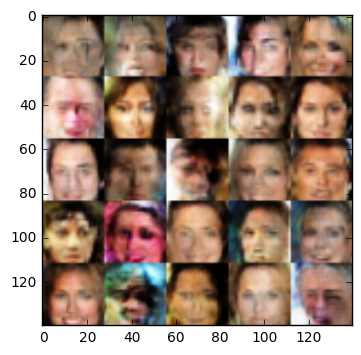

Epoch 1/1... Discriminator Loss: 1.4176... Generator Loss: 0.4550
Epoch 1/1... Discriminator Loss: 0.9697... Generator Loss: 1.4047


In [13]:
batch_size = 100
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.